In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

2024-05-05 13:35:27.596384: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Sequence classification task/experiment:

Notes:

- loss dropped very quickly, however the attention scores are uniformly distributed for every combination; its likely that the same results would occur even for a normal neural network, as no self-attending within the sequences is happening.
- this is however, with no positional embedding. We can test how the observed self-attention scores change when the sequences become harder and when positional embedding is added. Right now however, the task appears to be too simple.
- turns out the reason the error dropped so easily is the same reason it happened on the BELKA set: there were way more negative labels than positive, so it just guessed negative for everything and was able to get good accuracy and error.

- positional encoding made a MASSIVE difference in the dynamics of the attention score updates.

- when the positive labels are not oversampled, the network will simply learn to classify everything as negative. Will need to look into oversampling while mitigating overfitting.
- training on oversampled data yields good accuracy on the original dataset. HOWEVER, the precision score is very bad, around 20%.
- on real datasets oversampling in this way will not be possible; instead oversampling will 
    be done by duplicating the positively labelled samples, which could have worse effects on generalization error.

In [2]:
MAX_LENGTH = 6
MIN_LENGTH = 4
MAX_TOKENS = 3
symbols = ['[PAD]','A','B','C','D']
symbols_dict = {'A':1,'B':2,'C':3,'D':4,'[PAD]':0}
def gen_seq(constant_len=False, k=4):
    n = MAX_LENGTH
    if constant_len==False:
        n = np.random.choice(np.arange(MIN_LENGTH,MAX_LENGTH+1))
    seq = np.random.choice(list(range(1,k+1)),size=n)
    seq = [symbols[i] for i in seq] + (MAX_LENGTH-n)*['[PAD]']

#     print(seq)
#     seq += (3-n)*['[PAD]']
#     yield seq, is_set(seq)
    return seq

def is_palindrome(x):
    n = 0
    for i in x:
        if i == '[PAD]':
            break
        n+=1
    for i in range(n//2):
        if x[i] != x[n-i-1]:
            return 0
    return 1

# the generator is currently implemented to alternate between 1 and 0-labelled samples, so final dataset contains an equal number of both.
def gen_data():
    prev = 1
    while True:
        seq = gen_seq(constant_len=False,k=MAX_TOKENS)
        label = is_palindrome(seq)
        if label == prev:
            continue
        prev = label
        seq = [symbols_dict[key] for key in seq]
        yield seq,label
        
def gen_data_unequal():
    while True:
        seq = gen_seq(constant_len=False,k=MAX_TOKENS)
        label = is_palindrome(seq)
        seq = [symbols_dict[key] for key in seq]
        yield seq,label

In [3]:
# positional encoding function (taken from the Tensorflow Transformer tutorial)
def positional_encoding(length, depth):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

    return tf.cast(pos_encoding, dtype=tf.float32)

# PositionalEmbedding layer class definition (taken from Tensorflow Transformer Tutorial) 
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model,mask_zero=True) #<-- ZERO-PADDING
        self.pos_encoding = positional_encoding(length=MAX_LENGTH, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = MAX_LENGTH
        x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

In [58]:
tr_data = tf.data.Dataset.from_generator(gen_data,output_signature=(tf.TensorSpec(shape=(MAX_LENGTH,),dtype=tf.int32),
                                                               tf.TensorSpec(shape=(),dtype=tf.int32))).shuffle(10).batch(20)

dense1 = tf.keras.layers.Dense(64,activation='relu')
dense2 = tf.keras.layers.Dense(64,activation='relu')
ffn = tf.keras.Sequential([dense1,dense2])

inputs = tf.keras.Input((MAX_LENGTH,))
# mask = tf.keras.layers.Masking(mask_value=0)(inputs)
# emb = tf.keras.layers.Embedding(MAX_TOKENS+1,16)(mask)
emb = PositionalEmbedding(MAX_TOKENS+1, 16)(inputs)

# <-- this is where we'd also include the positional encoding
mha = tf.keras.layers.MultiHeadAttention(num_heads=3,key_dim=32,dropout=0.2)
x = mha(query=emb,value=emb) + emb
x = tf.keras.layers.LayerNormalization()(x) #+ emb) # shape (batch,seq_len,d_model)
x = ffn(x)
# <-- residual connection + layernorm again?
outputs = tf.keras.layers.EinsumDense('abc,cd->ad', output_shape=1)(x)

classifier = tf.keras.Model(inputs=inputs, outputs=outputs)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
opt = tf.keras.optimizers.Adam(1e-3)
classifier.compile(opt,loss)


In [ ]:
m = tf.keras.layers.Embedding(4,3,mask_zero=True)
a = m(tf.constant([1,2,3,0,0]))
print(a)
a._keras_mask

In [59]:
losses=[]

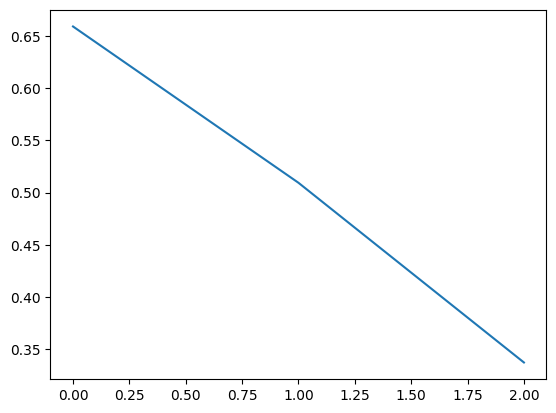

In [60]:
history = classifier.fit(tr_data,epochs=3,steps_per_epoch=300)
losses+=history.history['loss']
clear_output()
plt.plot(losses)

In [7]:
acc = tf.keras.metrics.BinaryAccuracy()

In [61]:
gen = gen_data_unequal()
test_data = [next(gen) for i in range(500)]
test_x,test_y = zip(*test_data)
test_x = np.array(test_x)
test_y = np.array(test_y)
print('% pos-labels in dataset: ', np.sum(test_y)/500)
pos_x = test_x[test_y==1]
neg_x = test_x[test_y!=1]
pred = tf.nn.sigmoid(classifier(tf.constant(test_x)))

acc.reset_state()
acc.update_state(test_y,pred)
print('overall accuracy: ', acc.result().numpy())
acc.reset_state()
acc.update_state(1,pred[test_y==1])
print('true positive accuracy (recall): ', acc.result().numpy())
acc.reset_state()
acc.update_state(0,pred[test_y==0])
print('true negative accuracy: ', acc.result().numpy())

acc.reset_state()
acc.update_state(test_y[pred[:,0]>0.5],1)
print('positive predictive value (precision): ', acc.result().numpy())

gen = gen_data()
test_data = [next(gen) for i in range(500)]
test_x,test_y = zip(*test_data)
pred = tf.nn.sigmoid(classifier(tf.constant(test_x)))
acc.reset_state()
acc.update_state(test_y,pred)
print('overall accuracy on oversampled dataset: ', acc.result().numpy())

% pos-labels in dataset:  0.098
overall accuracy:  0.832
true positive accuracy (recall):  0.97959185
true negative accuracy:  0.8159645
positive predictive value (precision):  0.36641222
overall accuracy on oversampled dataset:  0.906


In [1256]:
classifier.save_weights('./palindr_cons_length')

In [25]:
def plot_attention_head(in_tokens, translated_tokens, attention):

    num_heads,query_seq_len,key_seq_len = attention.shape
    fig,ax=plt.subplots(1,num_heads,figsize=(15,10))
    for i in range(num_heads):
        ax[i].matshow(attention[i,:,:])
        ax[i].set_xticks(range(len(in_tokens)))
        ax[i].set_yticks(range(len(translated_tokens)))
        ax[i].set_title(f'Attention head #{i}')

        labels = in_tokens
        ax[i].set_xticklabels(
          labels, rotation=90)

        labels = translated_tokens
        ax[i].set_yticklabels(labels)
    return fig

In [62]:
embed = classifier.layers[1](tf.constant(test_x))
_,atten_scores=mha(embed,embed, return_attention_scores=True)


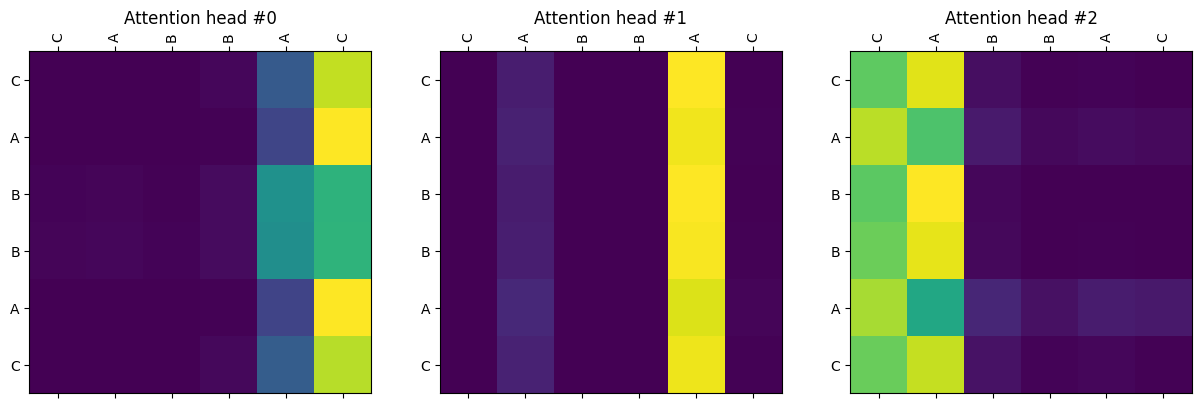

In [68]:
sample=5
# atten_weights = atten_scores[1,0,:,:]
in_tokens = [symbols[i] for i in test_x[sample]]

# fig = plt.subplots(1,3,figsize=(15,5))
fig = plot_attention_head(in_tokens,in_tokens,atten_scores[sample,:,:,:])


# plot_attention_head(in_tokens,in_tokens,atten_scores[sample,1,:,:])
# plt.show()

In [69]:
fig.savefig('./attention_map3.png')